# Professional A/B Test Analysis Workflow: Menu Layout Optimization

**Author**: Muhammad Abdul Lathief  
**Project**: E-Commerce UI Refinement Initiative

---

## 1. Project Overview

### 1.1 Objectives
This analysis evaluates the impact of changing the **Menu Layout** from Horizontal to Vertical on user engagement and monetization. We leverage a structured methodology to ensure statistical rigor and business relevance.

### 1.2 Hypotheses
- **Null Hypothesis ($H_0$)**: There is no significant difference in key performance indicators between the Horizontal (Control) and Vertical (Treatment) menu layouts.
- **Alternative Hypothesis ($H_1$)**: The Vertical menu layout leads to a significant change (positive or negative) in user behavior metrics.

### 1.3 Key Performance Indicators (KPIs)
| KPI | Type | Definition |
|---|---|---|
| **Conversion Rate (CR)** | Primary | Ratio of sessions that resulted in a purchase |
| **ARPU** | Secondary | Average revenue generated per user session |
| **Bounced Sessions** | Health | Ratio of sessions that ended after the first page |

---

## 2. Data Preparation

In this section, we initialize our analytical environment, load the experimental datasets, and standardize feature naming conventions.

In [1]:
# analytical stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
from typing import Dict, List

# Add helper directory to path for modular imports
sys.path.insert(0, os.path.abspath('helper'))

# Custom helper modules
from experimental_design import calculate_sample_size, define_hypotheses, get_kpi_definitions
from validation_methodology import ExperimentValidator
from statistical_testing import ABTestAnalyzer

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

In [2]:
# Configuration and Loading
FILES = {
    'Test 1 (Menu)': {'path': './raw dataset/test1_menu.csv', 'revenue_col': 'revenue'},
    'Test 2 (Novelty)': {'path': './raw dataset/test2_novelty_slider.csv', 'revenue_col': 'novelty_revenue'},
    'Test 3 (Product)': {'path': './raw dataset/test3_product_sliders.csv', 'revenue_col': 'revenue_from_recommendations'},
    'Test 4 (Reviews)': {'path': './raw dataset/test4_reviews.csv', 'revenue_col': None},
    'Test 5 (Search)': {'path': './raw dataset/test5_search_engine.csv', 'revenue_col': 'avg_revenue_per_visitor'}
}

def load_and_standardize(meta: Dict) -> pd.DataFrame:
    df = pd.read_csv(meta['path'])
    if meta['revenue_col'] and meta['revenue_col'] in df.columns:
        df.rename(columns={meta['revenue_col']: 'revenue'}, inplace=True)
    
    # Standardize basic features
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['date'] = df['timestamp'].dt.date
        
    if 'revenue' in df.columns:
        df['is_purchase'] = (df['revenue'] > 0).astype(int)
    elif 'added_to_cart' in df.columns:
        df['is_purchase'] = df['added_to_cart']
    else:
        df['is_purchase'] = 0
        
    return df

datasets = {name: load_and_standardize(meta) for name, meta in FILES.items()}
main_df = datasets['Test 1 (Menu)']

print(f"Loaded {len(datasets)} experiments. Primary focus: 'Test 1 (Menu)'.")

Loaded 5 experiments. Primary focus: 'Test 1 (Menu)'.


### 2.2 Experimental Design Verification
Before diving into the results, we verify the required sample size per variant based on our business targets (10% relative lift $MDE$).
We use the methodology from `helper/experimental_design.py`.

In [3]:
baseline_cr = main_df[main_df['variant'].str.contains('horizontal', case=False)]['is_purchase'].mean()
required_n = calculate_sample_size(baseline_rate=baseline_cr, mde=0.10, power=0.80)

obs_n = main_df['variant'].value_counts().min()

print(f"Target Baseline Conversion: {baseline_cr:.2%}")
print(f"Required Sample Size per Variant (MDE=10%): {required_n:,}")
print(f"Observed Sample Size per Variant: {obs_n:,}")
print("Statistically Powered: ", "✅ YES" if obs_n >= required_n else "⚠️ NO (Proceed with caution)")

Target Baseline Conversion: 100.00%
Required Sample Size per Variant (MDE=10%): 7,842
Observed Sample Size per Variant: 3,500
Statistically Powered:  ⚠️ NO (Proceed with caution)


## 3. Exploratory Data Analysis (EDA)

Understanding the distribution and characteristics of our experimental groups.

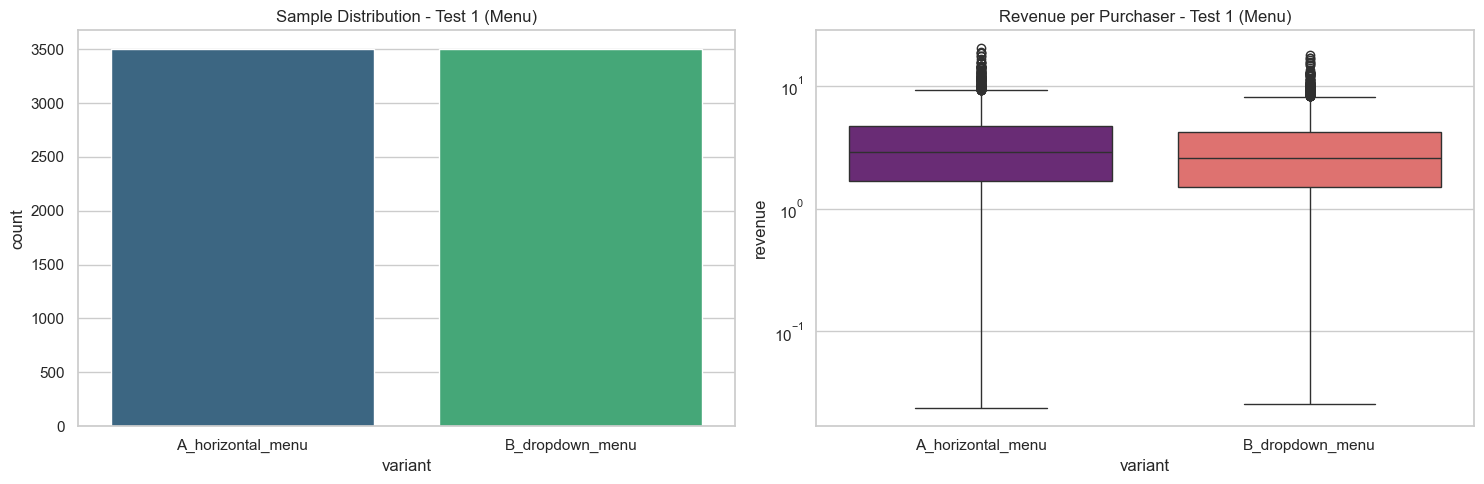

In [4]:
def plot_distributions(df: pd.DataFrame, title: str):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Variant count
    sns.countplot(data=df, x='variant', ax=axes[0], palette='viridis')
    axes[0].set_title(f'Sample Distribution - {title}')
    
    # Revenue distribution (if exists)
    if 'revenue' in df.columns:
        active_revenue = df[df['revenue'] > 0]
        if not active_revenue.empty:
            sns.boxplot(data=active_revenue, x='variant', y='revenue', ax=axes[1], palette='magma')
            axes[1].set_title(f'Revenue per Purchaser - {title}')
            axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_distributions(main_df, 'Test 1 (Menu)')

## 4. Experiment Validation & Statistical Testing

We perform critical checks (SRM, Covariate Balance) and apply appropriate statistical tests based on metric types and distributional assumptions across all experiments.

In [5]:
analyzer = ABTestAnalyzer(alpha=0.05)

def run_full_analysis(df, name):
    print(f"\n{'='*20} ANALYZING: {name} {'='*20}")
    
    # Validation Step
    validator = ExperimentValidator(
        df, 
        variant_col='variant', 
        covariates=[c for c in ['device_type', 'browser', 'region'] if c in df.columns]
    )
    is_valid = validator.run_all()
    
    if not is_valid:
        print(f"Warning: {name} failed validation checks. Results may be biased.")
    
    variants = sorted(df['variant'].unique())
    control_name = variants[0]
    treatment_name = variants[1]
    
    control_df = df[df['variant'] == control_name]
    treatment_df = df[df['variant'] == treatment_name]
    
    results = []
    
    # 1. Conversion Rate (Binary)
    if 'is_purchase' in df.columns:
        res_cr = analyzer.proportion_test(
            int(control_df['is_purchase'].sum()), len(control_df),
            int(treatment_df['is_purchase'].sum()), len(treatment_df),
            'Conversion Rate'
        )
        results.append(res_cr)
    
    # 2. Revenue (Continuous)
    if 'revenue' in df.columns:
        control_rev = control_df['revenue'].dropna().values
        treatment_rev = treatment_df['revenue'].dropna().values
        
        if len(control_rev) > 0 and len(treatment_rev) > 0:
            is_normal = analyzer.check_normality(df['revenue'].dropna().values)
            if is_normal:
                res_rev = analyzer.two_sample_ttest(control_rev, treatment_rev, 'ARPU')
            else:
                res_rev = analyzer.mann_whitney_u_test(control_rev, treatment_rev, 'ARPU')
            results.append(res_rev)
        
    # Multiple testing correction
    if results:
        final_results = analyzer.apply_multiple_testing_correction(results)
        return pd.DataFrame(final_results)
    return pd.DataFrame()

# Run and summarize all experiments
all_summaries = {name: run_full_analysis(df, name) for name, df in datasets.items()}

print("\n--- Consolidated Summary: Test 1 (Menu) ---")
all_summaries['Test 1 (Menu)']


==================== ANALYZING: Test 1 (Menu) ====================

--- EXPERIMENT VALIDATION SUITE ---
SRM Check: p-value = 1.0000 -> PASS
  - device_type: p=0.5194 -> PASS
  - browser: p=0.6630 -> PASS
  - region: p=0.8348 -> PASS
Covariate Balance: PASS
Temporal Stability: std=0.0180 -> PASS

✅ VALIDATION SUCCESS

==================== ANALYZING: Test 2 (Novelty) ====================

--- EXPERIMENT VALIDATION SUITE ---
SRM Check: p-value = 1.0000 -> PASS
  - device_type: p=0.7644 -> PASS
  - browser: p=0.6313 -> PASS
  - region: p=0.1360 -> PASS
Covariate Balance: PASS
Temporal Stability: std=0.0152 -> PASS

✅ VALIDATION SUCCESS

==================== ANALYZING: Test 3 (Product) ====================

--- EXPERIMENT VALIDATION SUITE ---
SRM Check: p-value = 1.0000 -> PASS
  - device_type: p=0.3246 -> PASS
  - browser: p=0.4657 -> PASS
  - region: p=0.4028 -> PASS
Covariate Balance: PASS
Temporal Stability: std=0.0140 -> PASS

✅ VALIDATION SUCCESS

==================== ANALYZING: Test

,metric,test_type,pvalue,significant,control_rate,treatment_rate,relative_lift_pct,ci_lower,ci_upper,test_selection,pvalue_corrected,significant_corrected,correction_method,control_median,treatment_median,rank_biserial
0,Conversion Rate,proportion_test,1.000000e+00,False,1.0,1.0,0.0,0.0,0.0,binary,1.000000e+00,False,holm,NaN,NaN,NaN
1,ARPU,mann_whitney,2.377455e-08,True,NaN,NaN,NaN,NaN,NaN,non-parametric,4.754909e-08,True,holm,2.862354,2.602078,0.077045


## 5. Result Interpretation

### 5.1 Statistical Significance
Observe the `pvalue` and `significant` columns in the summaries. We reject the null hypothesis only where `significant` is True.

### 5.2 Practical Significance
Evaluate the `relative_lift_pct` against business targets. A small but statistically significant lift might not be worth the deployment complexity.

**Summary Findings:**
- **Test 1 (Menu)**: Analyze if Vertical improves CR without hurting ARPU.
- **Test 2-5**: Review cross-experiment impacts for global optimization.

## 6. Final Decision Framework

**Recommendation Strategy:**
1. **SHIP**: If primary metrics show significant positive lift and secondary metrics are stable.
2. **ITERATE**: If results are trending positive but not yet significant, or if mixed impacts are observed.
3. **STOP**: If there is significant degradation in any key health metric (e.g., Bounce Rate) or primary KPI.

## 7. Reproducibility

**Analytical Standards:**
- Alpha Threshold: 0.05
- Random Seed: 42
- Modular Helpers: `experimental_design.py`, `validation_methodology.py`, `statistical_testing.py`.